In [20]:
from montecarlo import *
from portfolio import *
import math

# montecarlo e ef
PERIODS = 252
dur = 20
riskFreeRate = 0.01
numPortfolios = 25

# randomwalk
NUM_YEARS = 10
NUM_MC_RUNS = 1000


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


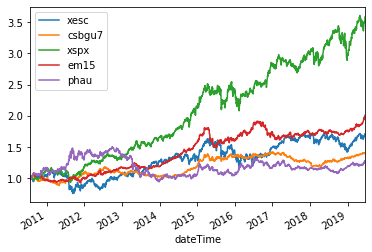

In [21]:
# data = pd.read_csv('quotes_clean_mach1.csv')  # daily quotes assets_all
#data = pd.read_csv('quote_mach2.csv')  # daily quotes assets_all
#data['dateTime'] = pd.to_datetime(data['dateTime'])
#data.set_index('dateTime', inplace=True)
assets_all = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau'] # **
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['iusa','imeu','ibtm','xgle','phau']
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['xgle', 'ibtm', 'iusa', 'smea', 'ieem']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
assets = ['xesc','xspx','phau','em15','csbgu7']
assets_all = ['xesc','xspx','phau','csbgu7','csbgu3','ibtm','em13','em35','em57','em710','em1015','em15']

data = read_quotes(assets)

# correzione SMEA
if 'smea' in assets:
    x1 = data.smea.idxmin()
    data.smea.loc[x1] = data.smea.loc[x1 - pd.Timedelta(days=1)]

norm_data = data/data.iloc[0]
norm_data.plot()
# data.head()

## Montecarlo e Efficient Frontier

In [22]:
## MONTECARLO e Efficient Frontier
## portafoglio maxSharpe e minVar

results, meanDailyReturns, covMatrix = do_mc_simulation(data, assets, numPortfolios, PERIODS, riskFreeRate)

# Find efficient frontier
targetReturns = np.linspace(0.02, 0.12, 20)
efficientPortfolios = findEfficientFrontier(meanDailyReturns, 
                                            covMatrix, targetReturns, PERIODS)

# Find portfolio with maximum Sharpe ratio
maxSharpe = findMaxSharpeRatioPortfolio(meanDailyReturns, covMatrix,
                                        riskFreeRate, PERIODS)
retms, sdms = calcPortfolioPerf(maxSharpe['x'], meanDailyReturns, covMatrix, PERIODS)

# Find portfolio with minimum variance
minVar = findMinVariancePortfolio(meanDailyReturns, covMatrix, PERIODS)
retmv, sdmv = calcPortfolioPerf(minVar['x'], meanDailyReturns, covMatrix, PERIODS) 
    

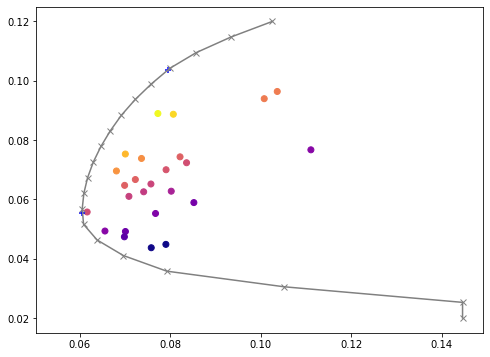

In [23]:
### PLOTTING

dfResults = results.copy()
dfResults = dfResults[['ret','vola','sharpe']]

fig10 = plt.figure(figsize = (8,6))
plt.scatter(dfResults.vola, dfResults.ret, c = dfResults.sharpe, marker = 'o', cmap='plasma')
plt.scatter(sdms, retms, c='blue', marker='+')
plt.scatter(sdmv, retmv, c='blue', marker='+')
plt.plot([p['fun'] for p in efficientPortfolios], targetReturns, marker='x', c='gray')

plt.show()



In [24]:
# Informazioni sul ptfolio migliore
# maxSharpe _fra_ i portafogli generati random

results.sharpe = pd.to_numeric(results.sharpe)
results.iloc[results.sharpe.idxmax()]

ret       0.0889576
vola      0.0772768
sharpe      1.02175
xesc      0.0184895
xspx       0.409143
phau      0.0642244
em15        0.24358
csbgu7     0.264563
Name: 2, dtype: object

## Montecarlo su tutte le combinazioni di portafogli

In [ ]:
# combinazioni degli asset a gruppi

from itertools import combinations 
  
def combine(arr, s): 
    return list(combinations(arr, s)) 

array = assets_all
set = 5
all_portfolio_combinations = combine(array, set)

all_results = pd.DataFrame(columns=['ret','vola','sharpe']+assets_all)

for num, asset_list in enumerate(all_portfolio_combinations):
    assets = list(asset_list)
    d = read_quotes(assets)
    # correzione SMEA
    if 'smea' in assets:
        x1 = d.smea.idxmin()
        d.smea.loc[x1] = d.smea.loc[x1 - pd.Timedelta(days=1)]
    
    results, meanDailyReturns, covMatrix = do_mc_simulation(d, assets, numPortfolios, PERIODS, riskFreeRate)

    results.sharpe = pd.to_numeric(results.sharpe)
    res = results.iloc[results.sharpe.idxmax()]
    
    print(asset_list, "{0:4.3f} {1:4.3f} {2:4.3f}".format(res.ret, res.vola, res.sharpe))
    #print(res)
    all_results = all_results.append(res)

In [53]:
all_results.to_csv('portfolio_combinations_mc_results.csv')

In [51]:
all_results.reset_index(drop=True, inplace=True)
all_results.sharpe = pd.to_numeric(all_results.sharpe)
all_results.iloc[all_results.sharpe.idxmax()]

ret       0.072205
vola      0.049395
sharpe    1.259360
xesc           NaN
xspx      0.228984
phau           NaN
csbgu7         NaN
csbgu3         NaN
ibtm           NaN
em13           NaN
em35           NaN
em57      0.220659
em710     0.295156
em1015    0.098677
em15      0.156524
Name: 539, dtype: float64

In [52]:
all_results.describe()

,ret,vola,sharpe,xesc,xspx,phau,csbgu7,csbgu3,ibtm,em13,em35,em57,em710,em1015,em15
count,792.000000,792.000000,792.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.056852,0.050963,0.908095,0.083823,0.299624,0.083014,0.174970,0.127505,0.098240,0.152168,0.207623,0.296065,0.309299,0.290194,0.277475
std,0.015496,0.011936,0.166471,0.057441,0.081937,0.057785,0.102075,0.086819,0.077413,0.102172,0.115603,0.118761,0.110248,0.115677,0.095181
min,0.022709,0.024090,0.469512,0.000083,0.063663,0.000612,0.000312,0.001388,0.000249,0.000255,0.001396,0.009589,0.000278,0.010971,0.001061
25%,0.044767,0.042631,0.802917,0.039017,0.244397,0.034931,0.095123,0.053125,0.039434,0.065812,0.103395,0.216291,0.249520,0.212554,0.215579
50%,0.054339,0.049406,0.870850,0.073797,0.292015,0.070921,0.178681,0.121506,0.081343,0.136242,0.219064,0.295100,0.300269,0.301691,0.281834
75%,0.068686,0.057943,1.040225,0.119815,0.347817,0.118075,0.243306,0.182628,0.129818,0.235848,0.300273,0.359262,0.363086,0.362426,0.341309
max,0.100371,0.098042,1.259360,0.276096,0.583360,0.280939,0.579892,0.457308,0.368812,0.467534,0.529768,0.687341,0.811622,0.645043,0.537134


## Random Walk

In [ ]:
# da runnare solo una volta, altrimenti rovina norm_data
pndata = norm_data.copy()

weights = minVar['x']
pndata['minvar'] = norm_data.mul(weights,axis=1).sum(axis=1)

weights = maxSharpe['x']
pndata['maxSharpe'] = norm_data.mul(weights,axis=1).sum(axis=1)

# pndata.head()

In [ ]:
pct_ret = pndata.pct_change()
pct_ret.dropna(inplace=True)
#pct_ret.head()

In [ ]:
mc_runs, ann_mc_returns, vol_mc_returns, sharpe_mc_runs = do_mc_randomwalk(pct_ret, 
                                                                           NUM_MC_RUNS, NUM_YEARS, 
                                                                           riskFreeRate, PERIODS)

In [ ]:
#plt.scatter(vol_mc_returns, ann_mc_returns, c = sharpe_mc_runs,marker = 'o')
#plt.colorbar(label = 'Sharpe Ratio')

In [ ]:
mc_stats = pd.DataFrame()
for i in [0,500,1000,1500,2000,mc_runs.shape[0]-1]:
    mc_stats[i] = mc_runs.iloc[i,:].describe([.1,.25,.5,.75,.9])

In [ ]:
# mc_stats

In [ ]:
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['10%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['90%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['50%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['25%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['75%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['min'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['max'], marker='o')
plt.show()

In [ ]:
# Statistiche solo sul risultato finale

mc_end_results = mc_runs.iloc[2520]

plt.hist(mc_end_results, bins=35)
plt.axvline(mc_end_results.quantile(0.05), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.95), color='r', linestyle='dashed', linewidth=2)
plt.show()